In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred
from statsmodels.tsa.ar_model import AutoReg
import warnings
warnings.filterwarnings('ignore') 

In [2]:
plt.rcParams["font.family"] = 'Times New Roman'  # 'serif', 'sans-serif', 'Times New Roman'
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams["figure.autolayout"] = True

In [3]:
fred = Fred()

### Load quarterly data on FRED

In [4]:
df = {}
ids = ['DGS1',      # 1-year treasury
       'TB3MS',     # 3-month treasury
       'CPIAUCNS']  # CPI
nms = ['i', 'i_3m', 'cpi']
for k in range(len(ids)):
    df[nms[k]] = fred.get_series(ids[k], frequency='q')

df = pd.DataFrame(df)

In [5]:
df.dropna().head()

,i,i_3m,cpi
1962-01-01,3.20,2.72,30.067
1962-04-01,3.01,2.72,30.200
1962-07-01,3.19,2.84,30.333
1962-10-01,2.99,2.81,30.400
1963-01-01,3.03,2.91,30.433


### Compute quarterly inflation rate

$$\text{inflation}_t = \frac{\text{CPI}_{t+4} - \text{CPI}_{t}}{\text{CPI}_t} 
$$

In [6]:
df['pi'] = df['cpi'].pct_change(periods=4).shift(-4) # realized (ex post) inflation rate
df['pi_lag'] = df['pi'].shift(1)  # lagged inflation rate
df['pi_exp'] = np.nan             # expected inflation rate

In [7]:
df.head()

,i,i_3m,cpi,pi,pi_lag,pi_exp
1913-01-01,NaN,NaN,9.800,0.013571,NaN,NaN
1913-04-01,NaN,NaN,9.767,0.010239,0.013571,NaN
1913-07-01,NaN,NaN,9.933,0.020135,0.010239,NaN
1913-10-01,NaN,NaN,10.033,0.009967,0.020135,NaN
1914-01-01,NaN,NaN,9.933,0.006745,0.009967,NaN


In [8]:
df.tail()

,i,i_3m,cpi,pi,pi_lag,pi_exp
2023-07-01,5.39,5.29,306.835,0.023126,0.031989,NaN
2023-10-01,5.23,5.28,307.156,NaN,0.023126,NaN
2024-01-01,4.90,5.23,310.358,NaN,NaN,NaN
2024-04-01,5.14,5.24,313.931,NaN,NaN,NaN
2024-07-01,4.57,NaN,NaN,NaN,NaN,NaN


### Compute expected inflation

We compute expected inflation using AR(4) model 

$$
\pi_t = \rho_0 + \rho_1 \pi_{t-1} + \cdots + \rho_4 \pi_{t-4} + \epsilon_t
$$

and inflation data for the past 30 years.

In [9]:
lags = 4
for k in range(30*lags, len(df['pi'][:'2023-10-01'])):
    dat = df['pi'][(max(k-30*lags-1,0)):(k-1)]  # inflation data for the past 30 years
    res = AutoReg(dat, lags).fit()              # estimate an AR(4) model for inflation
    df['pi_exp'][k-1] = res.predict(start=len(dat), end=len(dat))  # the predicted inflation

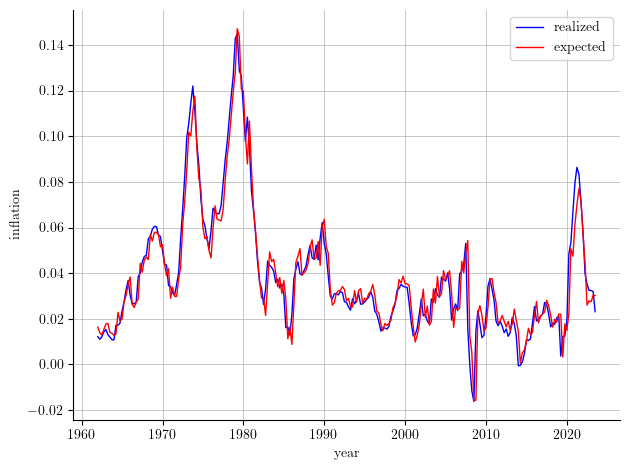

In [10]:
fig, ax = plt.subplots()
ty = '1962-01-01'
ax.plot(df['pi'][ty:], c='b', lw=1, label='realized')
ax.plot(df['pi_exp'][ty:], c='r', lw=1, label='expected')
ax.set_ylabel('inflation')
ax.set_xlabel('year')
ax.grid(lw=0.5)
ax.legend()
plt.show()

In [11]:
df.head()

,i,i_3m,cpi,pi,pi_lag,pi_exp
1913-01-01,NaN,NaN,9.800,0.013571,NaN,NaN
1913-04-01,NaN,NaN,9.767,0.010239,0.013571,NaN
1913-07-01,NaN,NaN,9.933,0.020135,0.010239,NaN
1913-10-01,NaN,NaN,10.033,0.009967,0.020135,NaN
1914-01-01,NaN,NaN,9.933,0.006745,0.009967,NaN


### Method 1. Compute and estimate real interest rate using 1-year treasury bill rate

In [12]:
df['R_post'] = (1 + df['i'].div(100)).div(1 + df['pi'])       # ex post real interest rate
df['R_ante'] = (1 + df['i'].div(100)).div(1 + df['pi_exp'])   # ex ante real interest rate
df['R_ante2'] = (1 + df['i'].div(100)).div(1 + df['pi_lag'])  # ex ante real interest rate 2
df = df.dropna()

In [13]:
df.head()

,i,i_3m,cpi,pi,pi_lag,pi_exp,R_post,R_ante,R_ante2
1962-01-01,3.20,2.72,30.067,0.012173,0.013333,0.016357,1.019589,1.015391,1.018421
1962-04-01,3.01,2.72,30.200,0.011026,0.012173,0.013830,1.018865,1.016048,1.017712
1962-07-01,3.19,2.84,30.333,0.012099,0.011026,0.012901,1.019564,1.018757,1.020646
1962-10-01,2.99,2.81,30.400,0.014243,0.012099,0.015381,1.015437,1.014299,1.017588
1963-01-01,3.03,2.91,30.433,0.015345,0.014243,0.017747,1.014729,1.012334,1.015831


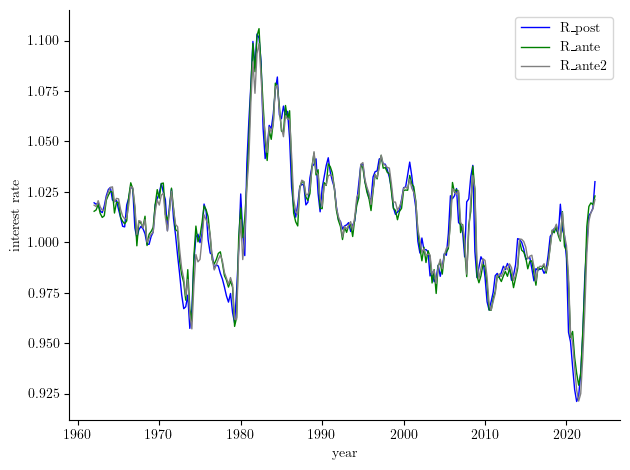

In [14]:
fig, ax = plt.subplots()
ax.plot(df['R_post'], lw=1, c='b', label='R_post')
ax.plot(df['R_ante'], lw=1, c='g', label='R_ante')
ax.plot(df['R_ante2'], lw=1, c='gray', label='R_ante2')
ax.set_ylabel('interest rate')
ax.set_xlabel('year')
ax.legend()
plt.show()

#### Prepare the dataset for estimation

In [15]:
R_post_ts = df['1962-01-01':'2022-01-01']['R_post']
R_ante_ts = df['1962-01-01':'2022-01-01']['R_ante']
R_ante2_ts = df['1962-01-01':'2022-01-01']['R_ante2']
df_ts = pd.concat((R_post_ts, R_ante_ts, R_ante2_ts), axis=1)

In [16]:
df_ts.describe()

,R_post,R_ante,R_ante2
count,241.000000,241.000000,241.000000
mean,1.010109,1.010205,1.010245
std,0.029624,0.028395,0.028009
min,0.921061,0.929133,0.921245
25%,0.990911,0.990049,0.991427
50%,1.008626,1.010387,1.010360
75%,1.026911,1.025915,1.026566
max,1.103291,1.105959,1.098561


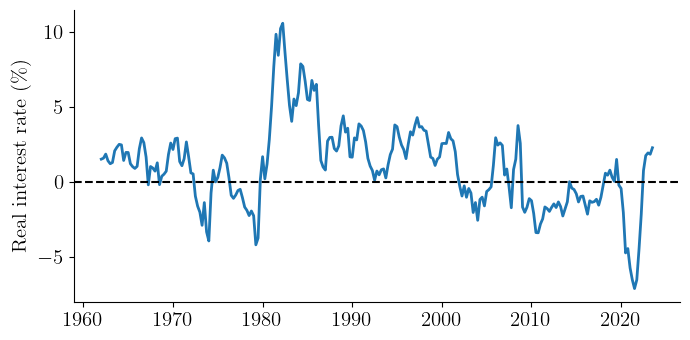

In [17]:
fig, ax = plt.subplots(figsize=(7,3.5))
ax.plot((df['R_ante']-1)*100, lw=2)
ax.axhline(0, ls='--', c='k', lw=1.5)
ax.set_ylabel('Real interest rate (\%)', fontsize=15, labelpad=5)
ax.tick_params(labelsize=15)
plt.savefig('../output/figures/real_rate.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

#### Estimate the AR(1) interest rate model

$$
R_t = \mu_R (1-\rho_R) + \rho_R R_{t-1} + \sigma_R \sqrt{1-\rho_R^2} \varepsilon_t^R,
\quad \{\varepsilon_t^R\} \overset{iid}{\sim} N(0,1)
$$

In [18]:
r_est = AutoReg(R_ante_ts, lags=1).fit()
r_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 R_ante   No. Observations:                  241
Model:                     AutoReg(1)   Log Likelihood                 760.367
Method:               Conditional MLE   S.D. of innovations              0.010
Date:                Tue, 17 Sep 2024   AIC                          -1514.734
Time:                        19:51:50   BIC                          -1504.293
Sample:                    04-01-1962   HQIC                         -1510.527
                         - 01-01-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0596      0.024      2.529      0.011       0.013       0.106
R_ante.L1      0.9407      0.023     40.327      0.000       0.895       0.986
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0630           +0.0000j            1.0630            0.0000
-----------------------------------------------------------------------------
"""

In [19]:
ρ_R = r_est.params[1]
μ_R = r_est.params[0] / (1-ρ_R)
σ_R = np.sqrt(r_est.sigma2) / np.sqrt(1-ρ_R**2)
print(f'μ_R = {μ_R}')
print(f'ρ_R = {ρ_R}')
print(f'σ_R = {σ_R}')

μ_R = 1.0062306068251645
ρ_R = 0.9407262699728842
σ_R = 0.030020587135876617


## Method 2. Compute and estimate real interest rate using 3-month treasury bill rate

In [20]:
df2 = df.copy()
df2['R_post'] = (1+df2['i_3m'].div(100)).div(1+df2['pi'])       # ex post real interest rate
df2['R_ante'] = (1+df2['i_3m'].div(100)).div(1+df2['pi_exp'])   # ex ante real interest rate
df2['R_ante2'] = (1+df2['i_3m'].div(100)).div(1+df2['pi_lag'])  # ex ante real interest rate 2

In [21]:
df2.head()

,i,i_3m,cpi,pi,pi_lag,pi_exp,R_post,R_ante,R_ante2
1962-01-01,3.20,2.72,30.067,0.012173,0.013333,0.016357,1.014846,1.010668,1.013684
1962-04-01,3.01,2.72,30.200,0.011026,0.012173,0.013830,1.015997,1.013187,1.014846
1962-07-01,3.19,2.84,30.333,0.012099,0.011026,0.012901,1.016106,1.015302,1.017184
1962-10-01,2.99,2.81,30.400,0.014243,0.012099,0.015381,1.013662,1.012527,1.015810
1963-01-01,3.03,2.91,30.433,0.015345,0.014243,0.017747,1.013547,1.011155,1.014648


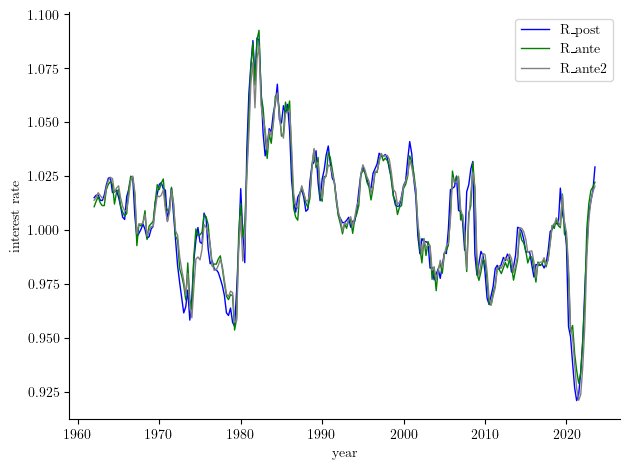

In [22]:
fig, ax = plt.subplots()
ax.plot(df2['R_post'], lw=1, c='b', label='R_post')
ax.plot(df2['R_ante'], lw=1, c='g', label='R_ante')
ax.plot(df2['R_ante2'], lw=1, c='gray', label='R_ante2')
ax.set_ylabel('interest rate')
ax.set_xlabel('year')
ax.legend()
plt.show()

#### Prepare the dataset for estimation

In [23]:
R_post_ts = df2['1962-01-01':'2022-01-01']['R_post']
R_ante_ts = df2['1962-01-01':'2022-01-01']['R_ante']
R_ante2_ts = df2['1962-01-01':'2022-01-01']['R_ante2']
df2_ts = pd.concat((R_post_ts, R_ante_ts, R_ante2_ts), axis=1)

In [24]:
df2_ts.describe()

,R_post,R_ante,R_ante2
count,241.000000,241.000000,241.000000
mean,1.005453,1.005546,1.005588
std,0.028016,0.026605,0.026310
min,0.920785,0.928854,0.920969
25%,0.986013,0.986271,0.987044
50%,1.005335,1.005871,1.005529
75%,1.021844,1.021143,1.022141
max,1.088909,1.092452,1.085144


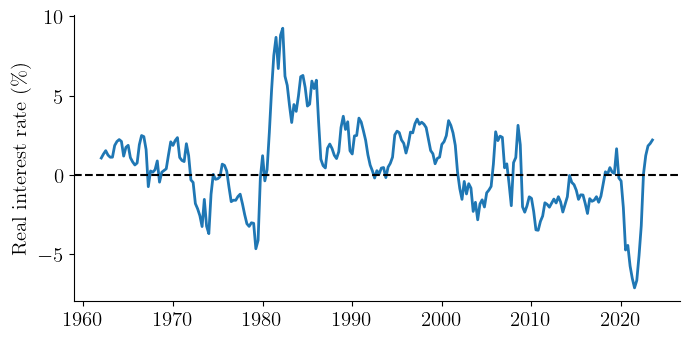

In [25]:
fig, ax = plt.subplots(figsize=(7,3.5))
ax.plot((df2['R_ante']-1)*100, lw=2)
ax.axhline(0, ls='--', c='k', lw=1.5)
ax.set_ylabel('Real interest rate (\%)', fontsize=15, labelpad=5)
ax.tick_params(labelsize=15)
plt.show()

#### Estimate the AR(1) interest rate model

$$
R_t = \mu_R (1-\rho_R) + \rho_R R_{t-1} + \sigma_R \sqrt{1-\rho_R^2} \varepsilon_t^R,
\quad \{\varepsilon_t^R\} \overset{iid}{\sim} N(0,1)
$$

In [26]:
r_est = AutoReg(R_ante_ts, lags=1).fit()
r_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 R_ante   No. Observations:                  241
Model:                     AutoReg(1)   Log Likelihood                 769.804
Method:               Conditional MLE   S.D. of innovations              0.010
Date:                Tue, 17 Sep 2024   AIC                          -1533.608
Time:                        19:51:51   BIC                          -1523.166
Sample:                    04-01-1962   HQIC                         -1529.400
                         - 01-01-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0615      0.024      2.550      0.011       0.014       0.109
R_ante.L1      0.9386      0.024     39.146      0.000       0.892       0.986
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0654           +0.0000j            1.0654            0.0000
-----------------------------------------------------------------------------
"""

In [27]:
ρ_R = r_est.params[1]
μ_R = r_est.params[0] / (1-ρ_R)
σ_R = np.sqrt(r_est.sigma2) / np.sqrt(1-ρ_R**2)
print(f'μ_R = {μ_R}')
print(f'ρ_R = {ρ_R}')
print(f'σ_R = {σ_R}')

μ_R = 1.0016149539082044
ρ_R = 0.9385890161059447
σ_R = 0.02837202908107753
